# 1. Business Understanding

## Project Motivation<a name="motivation"></a>

This project is part of Udacity Data Scientist Nano-Degree. <br>For this project, my biggest interest whould be -- how real word data scientist look like?

## Goal

We will dig into latest 2020 Stack Overflow Developer survey conducted in 2020 Feburary at <a href=" https://insights.stackoverflow.com/survey">here</a><br>
Based on our reachable survey data and the motivation, we can define our goal into answering these 4 questions:
1. Who are data scientist? Whats their profile?
2. What's the difference between data scientist and other developers
3. What tools (language, platform…) do data scientists use?
4. What are important predictors for data scientist who has higher converted compensation?

# 2. Data Understanding

### Import Basic Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns; sns.set()
import math
from collections import Counter
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#read data
df = pd.read_csv('survey_results_public.csv')

### Get the basic numbers of the survey

In [3]:
hired_respondant = df[~df["DevType"].isnull()]
print("All respondant: ",len(df))
print("hired respondants: ",len(hired_respondant))

All respondant:  64461
hired respondants:  49370


In [4]:
hired_respondant.head(3)

Respondent                      MainBranch Hobbyist  Age Age1stCode  \
0           1  I am a developer by profession      Yes  NaN         13   
1           2  I am a developer by profession       No  NaN         19   
5           6  I am a developer by profession       No  NaN         14   

  CompFreq  CompTotal  ConvertedComp         Country    CurrencyDesc  ...  \
0  Monthly        NaN            NaN         Germany   European Euro  ...   
1      NaN        NaN            NaN  United Kingdom  Pound sterling  ...   
5      NaN        NaN            NaN         Germany   European Euro  ...   

                   SurveyEase           SurveyLength Trans  \
0  Neither easy nor difficult  Appropriate in length    No   
1                         NaN                    NaN   NaN   
5  Neither easy nor difficult  Appropriate in length   NaN   

                                      UndergradMajor WebframeDesireNextYear  \
0  Computer science, computer engineering, or sof...           ASP.NET Core   
1  Computer science, computer engineering, or sof...                    NaN   
5                                                NaN               React.js   

     WebframeWorkedWith                             WelcomeChange WorkWeekHrs  \
0  ASP.NET;ASP.NET Core   Just as welcome now as I felt last year        50.0   
1                   NaN  Somewhat more welcome now than last year         NaN   
5                   NaN                                       NaN         NaN   

  YearsCode YearsCodePro  
0        36           27  
1         7            4  
5         6            4  

[3 rows x 61 columns]

## What are the distribution of developer types?
* what are the developer types of our respondant?
* what type is the mainstream?
* how much data scientist are there?

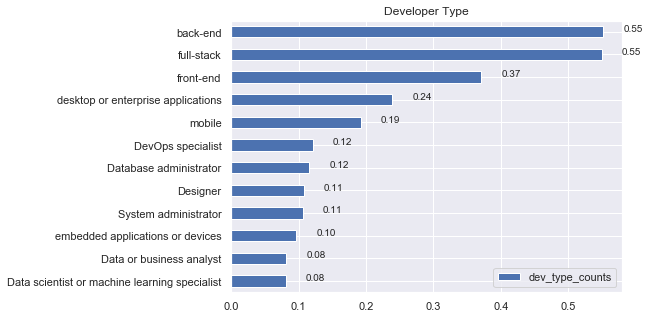

In [5]:
#get basic types from survey scheme
dev_types=["full-stack","back-end","front-end","mobile","desktop or enterprise applications", "embedded applications or devices", "Data scientist or machine learning specialist", "Database administrator", "Data or business analyst","DevOps specialist","Designer","System administrator"]

# get the counts of each given dev_types
count_of_DevType=[]
for dev_type in dev_types:
    count = len(df[df["DevType"].str.contains(dev_type, regex=True,na=False)])
    count_of_DevType.append(count)

#generate horizontal bar chart    
result =pd.DataFrame(data=np.array(count_of_DevType)/len(hired_respondant),index=dev_types, columns=['dev_type_counts'])
ax = result.sort_values(by=['dev_type_counts']).plot(kind='barh',figsize=(7,5),title='Developer Type');
for p in ax.patches:
    plt.text(0.03+p.get_width(), p.get_y()+0.55*p.get_height(),'{:1.2f}'.format(p.get_width()))

###### Findings at a glimps:
* it seems like data scientist or analyst aren't much in the industry (8% + 8%)
* the most popular types are back-end & full-stack & front-end

##  Select Interesting Columns
* you can pick what you like -- i just pick mine
* there are 3 types of question in the questionaires (also in other standard questionaires), you should put your interested columns into one of these types
    * numerical questions
    * multi-select questions
    * multiple choice questions

In [6]:
numeric_columns = ["Age", "Age1stCode", "ConvertedComp", "WorkWeekHrs", "YearsCode", "YearsCodePro"]
multi_sel_columns = ["Country", "EdLevel","NEWOvertime", "JobSat", "OrgSize", "UndergradMajor","NEWLearn","Hobbyist"]
multi_choice_columns = ["JobFactors", "DatabaseWorkedWith","WebframeWorkedWith","LanguageWorkedWith", "PlatformWorkedWith","NEWCollabToolsWorkedWith"]

##  Picking developer types 
* you can pick what you like -- i just pick mine
* I am interested in the difference between **data scientist**, **front-end**, **back-end** developers

In [7]:
#filter out those developer's data
df_interested = hired_respondant[["DevType"] + numeric_columns + multi_sel_columns + multi_choice_columns].copy()
df_interested["DevType"] = df_interested["DevType"].apply(lambda x:"Data Scientist" if (("Data scientist"in x)or("business analyst"in x)) \
                                                          else ("front-end" if ('front-end' in x) else ("back-end" if ('back-end' in x) else "none")))
df_interested = df_interested[df_interested.DevType!='none']

## Exploring & Analytics
since we are ready for our analytics, lets analyze data base on 3 types of questions
* numerical questions
* multi-select questions
* multiple choice questions

### 1. Numerical Data Overview

#### Data Wrangling
Most of the numeric data can be used directely; however, we found some of the columns are not directly applicable, so we'll need some easy data wrangling

In [8]:
def convert_yearString_to_int(df, column):
    '''
    data cleaning for specific year-based column
    '''
    df[column] = df[column].apply(lambda x: 0.5 if x == 'Less than 1 year' \
                                  else ( 60 if x == 'More than 50 years' \
                                        else( int(x) if isinstance(x,str) else np.nan)))
    return df

In [9]:
convert_yearString_to_int(df_interested,"YearsCodePro")
convert_yearString_to_int(df_interested,"YearsCode")
df_interested["Age1stCode"] = df_interested["Age1stCode"].apply(lambda x: 4 if x == 'Younger than 5 years' \
                                  else ( 90 if x == 'Older than 85' else( int(x) if isinstance(x,str) else np.nan))) 

In [10]:
df_interested.describe()

Age    Age1stCode  ConvertedComp   WorkWeekHrs     YearsCode  \
count  28046.000000  34943.000000   2.479400e+04  29253.000000  34862.000000   
mean      31.740854     15.400452   1.027908e+05     40.739677     13.604340   
std        8.572320      5.104616   2.278192e+05     18.026040      9.482592   
min        1.000000      4.000000   0.000000e+00      1.000000      0.500000   
25%       26.000000     12.000000   2.378200e+04     40.000000      7.000000   
50%       30.000000     15.000000   5.217500e+04     40.000000     11.000000   
75%       36.000000     18.000000   9.453225e+04     44.000000     19.000000   
max       99.000000     90.000000   2.000000e+06    425.000000     60.000000   

       YearsCodePro  
count  32421.000000  
mean       8.490068  
std        7.741967  
min        0.500000  
25%        3.000000  
50%        6.000000  
75%       12.000000  
max       60.000000

**Note:** it's not easy to understand the distribution by "describe"

#### Scalable KDE(kernel density estimation)
Generate Kernel Density Estimate plot using Gaussian kernels.

In [11]:
def remove_numeric_outlier(df):
    analysis_data = df.copy()
    for column in list(analysis_data.select_dtypes(include='float64').columns):
        current_column = analysis_data[column]
        lower_bound = current_column.quantile(.1)
        upper_bound = current_column.quantile(.9)
        analysis_data[column] = analysis_data[column].apply(lambda x: np.nan if ((x<lower_bound)or (x > upper_bound)) else x)
    return analysis_data

In [ ]:
#our interested developer type groups
dev_types_agg = ["Data Scientist","front-end","back-end"]

#decide how much row to plot
plot_rows = math.ceil(len(numeric_columns)/3)
analysis_data = remove_numeric_outlier(df_interested)

#plot numeric data columns at scale
fig_kde, axis_kde = plt.subplots(plot_rows,3, figsize=(18, 4*plot_rows))
for attr_index in range(len(numeric_columns)):
    attr = numeric_columns[attr_index]

    #set index
    index_0, index_1 = math.floor(attr_index/3), attr_index%3
    axis_kde[index_0][index_1].set_title(attr)

    #plot data
    for dev_type in dev_types_agg:
        sns.kdeplot(analysis_data[attr][analysis_data.DevType==dev_type], label=dev_type, ax=axis_kde[index_0][index_1],shade=True); #shade 線下顏色

### We want to check the percentage of <font color=red> null data </font>  in each numeric column.

In [13]:
# we would like to compute "notnull count / total count"

devType_count = analysis_data["DevType"].value_counts()
notnull_counts = analysis_data[["DevType"]+list(analysis_data.select_dtypes(include='float64').columns)].groupby("DevType").count()
for devtype in dev_types_agg:
    notnull_counts.loc[devtype, :] = notnull_counts.loc[devtype, :]/devType_count[devtype]

In [14]:
print("Not null percentage for each type: ")
notnull_counts

Not null percentage for each type: 


Age  Age1stCode  ConvertedComp  WorkWeekHrs  YearsCode  \
DevType                                                                       
Data Scientist  0.611020    0.781534       0.525838     0.658972   0.769471   
back-end        0.672706    0.844249       0.595246     0.756400   0.840758   
front-end       0.657565    0.823041       0.564352     0.715350   0.827622   

                YearsCodePro  
DevType                       
Data Scientist      0.755920  
back-end            0.831200  
front-end           0.818521

### **Note:** We will  <font color=red>  ignore the null data </font>, since they seem to present in random (all 3 group have similar Not NULL percentage (within 10%). For our purpose, this is acceptable.

###### Findings at a glimps:
* front-end developers are more young in the community -- lower age, years code, year code pro...
* we can see that these the distribution of these 3 variables looks quite similar. And it's reasonable to say that higher YearsCode result in higher ConvertedComp. 
* From this point of view, we found though data scientist has lower YearsCode than back-end developer, they still have good converted compensation than other developers.

### 2. Categorical Data Overview

In [15]:
print("categorical: ",multi_sel_columns)

categorical:  ['Country', 'EdLevel', 'NEWOvertime', 'JobSat', 'OrgSize', 'UndergradMajor', 'NEWLearn', 'Hobbyist']


In [16]:
def plot_categorical_graph(df, col, index_0, index_1):
    #group each categorical column by their value, and select most frequent values
    top_5 = list(df.groupby(col)["DevType"].count().sort_values().tail(5).index)
    df[col] = df[col].apply(lambda x: x if (x in top_5) else "Other")

    #prepare temporary dataframe (groupby value in percentage) for plotting
    devtype_groupby_value = df.groupby("DevType")[col].value_counts()
    devtype_group_count = df.groupby("DevType")[col].count()
    groupby_value_percentage = devtype_groupby_value / devtype_group_count
    data = groupby_value_percentage.to_frame().rename({col: 'group_percentage'}, axis=1).reset_index()

    #select top 3 words for representing the value
    data[col] = data[col].apply(lambda x: ' '.join(x.split(" ")[0:3]))
    
    #plot data
    sns.barplot(x=col, y='group_percentage', hue='DevType', data=data, ax=axis[index_0,index_1]);

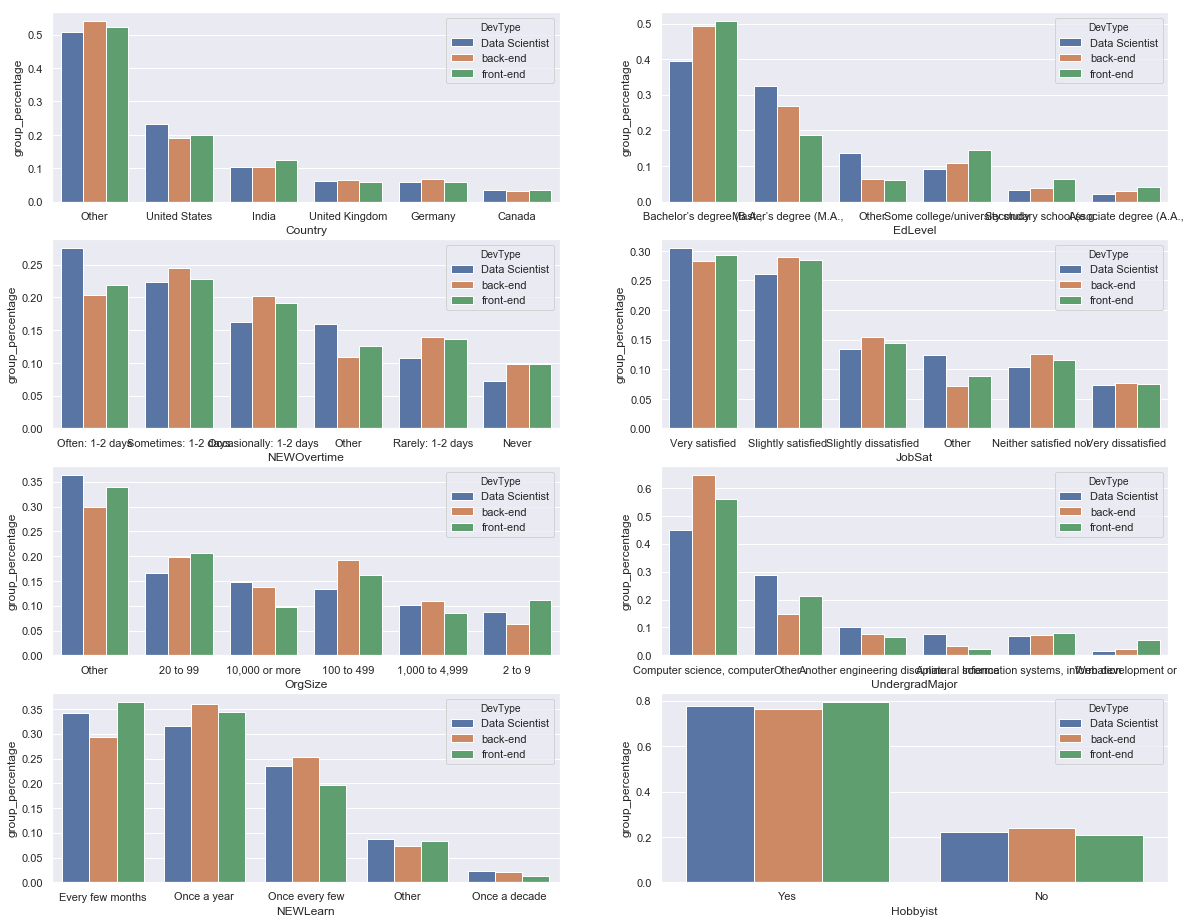

In [17]:
#decide how much row to plot
plot_rows = math.ceil(len(multi_sel_columns)/2)

#basic setup
data = df_interested.copy()
fig, axis = plt.subplots(plot_rows,2,figsize=(20,4*plot_rows))

#plot categorical data columns at scale
index = 0
for col in multi_sel_columns:
    index_0, index_1 = math.floor(index/2), index%2
    plot_categorical_graph(data, col, index_0 , index_1)
    index = index+1

### **Note:** We will <font color=red> ignore the null data </font>, since we are computing percentage of each selection within each group. , also they seem to present in random (all 3 group have similar Not NULL percentage (within 10%). For our purpose, this is acceptable.

In [29]:
# we would like to compute "notnull count / total count"
devType_count = analysis_data["DevType"].value_counts()
cate_notnull_counts = analysis_data[["DevType"]+list(df_interested[multi_sel_columns].columns)].groupby("DevType").count()
for devtype in dev_types_agg:
    cate_notnull_counts.loc[devtype, :] = cate_notnull_counts.loc[devtype, :]/devType_count[devtype]

In [31]:
print("Not null data percentage")
cate_notnull_counts

Not null data percentage


Country   EdLevel  NEWOvertime    JobSat   OrgSize  \
DevType                                                              
Data Scientist      1.0  0.982874     0.841102  0.876396  0.859717   
back-end            1.0  0.981300     0.890376  0.927610  0.914644   
front-end           1.0  0.977033     0.873435  0.910818  0.894753   

                UndergradMajor  NEWLearn  Hobbyist  
DevType                                             
Data Scientist        0.920179  0.913179       1.0  
back-end              0.935672  0.926945       1.0  
front-end             0.897868  0.916926       1.0

###### Findings at a glimps:
* US have more data scientist percentage than others
* higher percentage of data scientists has a master degree
* higher percentage of data scientists comes from not computer-related background
* higher percentage of data scientists works in larger company

### Multiple Choice Data Overview
* multi-choice data have lots of infomration, but could be hard to analyze without proper parsing
* Our goal is to understand
    1. how popular is any givin choice?
    2. how is the difference between 3 types of developers? (data scientist, back-end, front-end)
* we want to parse it by 
    1. split the data by ";" 
    2. count their occurence
    3. sort by value & plot their occurence 

In [18]:
#lets take a look at the original data
df_interested[multi_choice_columns].head(3)

JobFactors   DatabaseWorkedWith  \
5  Diversity of the company or organization;Langu...                  NaN   
6                                                NaN                  NaN   
7  Remote work options;Opportunities for professi...  MariaDB;MySQL;Redis   

  WebframeWorkedWith        LanguageWorkedWith        PlatformWorkedWith  \
5                NaN  HTML/CSS;Java;JavaScript  Android;Docker;WordPress   
6                NaN           C#;HTML/CSS;PHP                       NaN   
7              Flask                Python;SQL                    Docker   

                            NEWCollabToolsWorkedWith  
5                     Confluence;Github;Slack;Trello  
6                                                NaN  
7  Confluence;Jira;Github;Slack;Microsoft Teams;G...

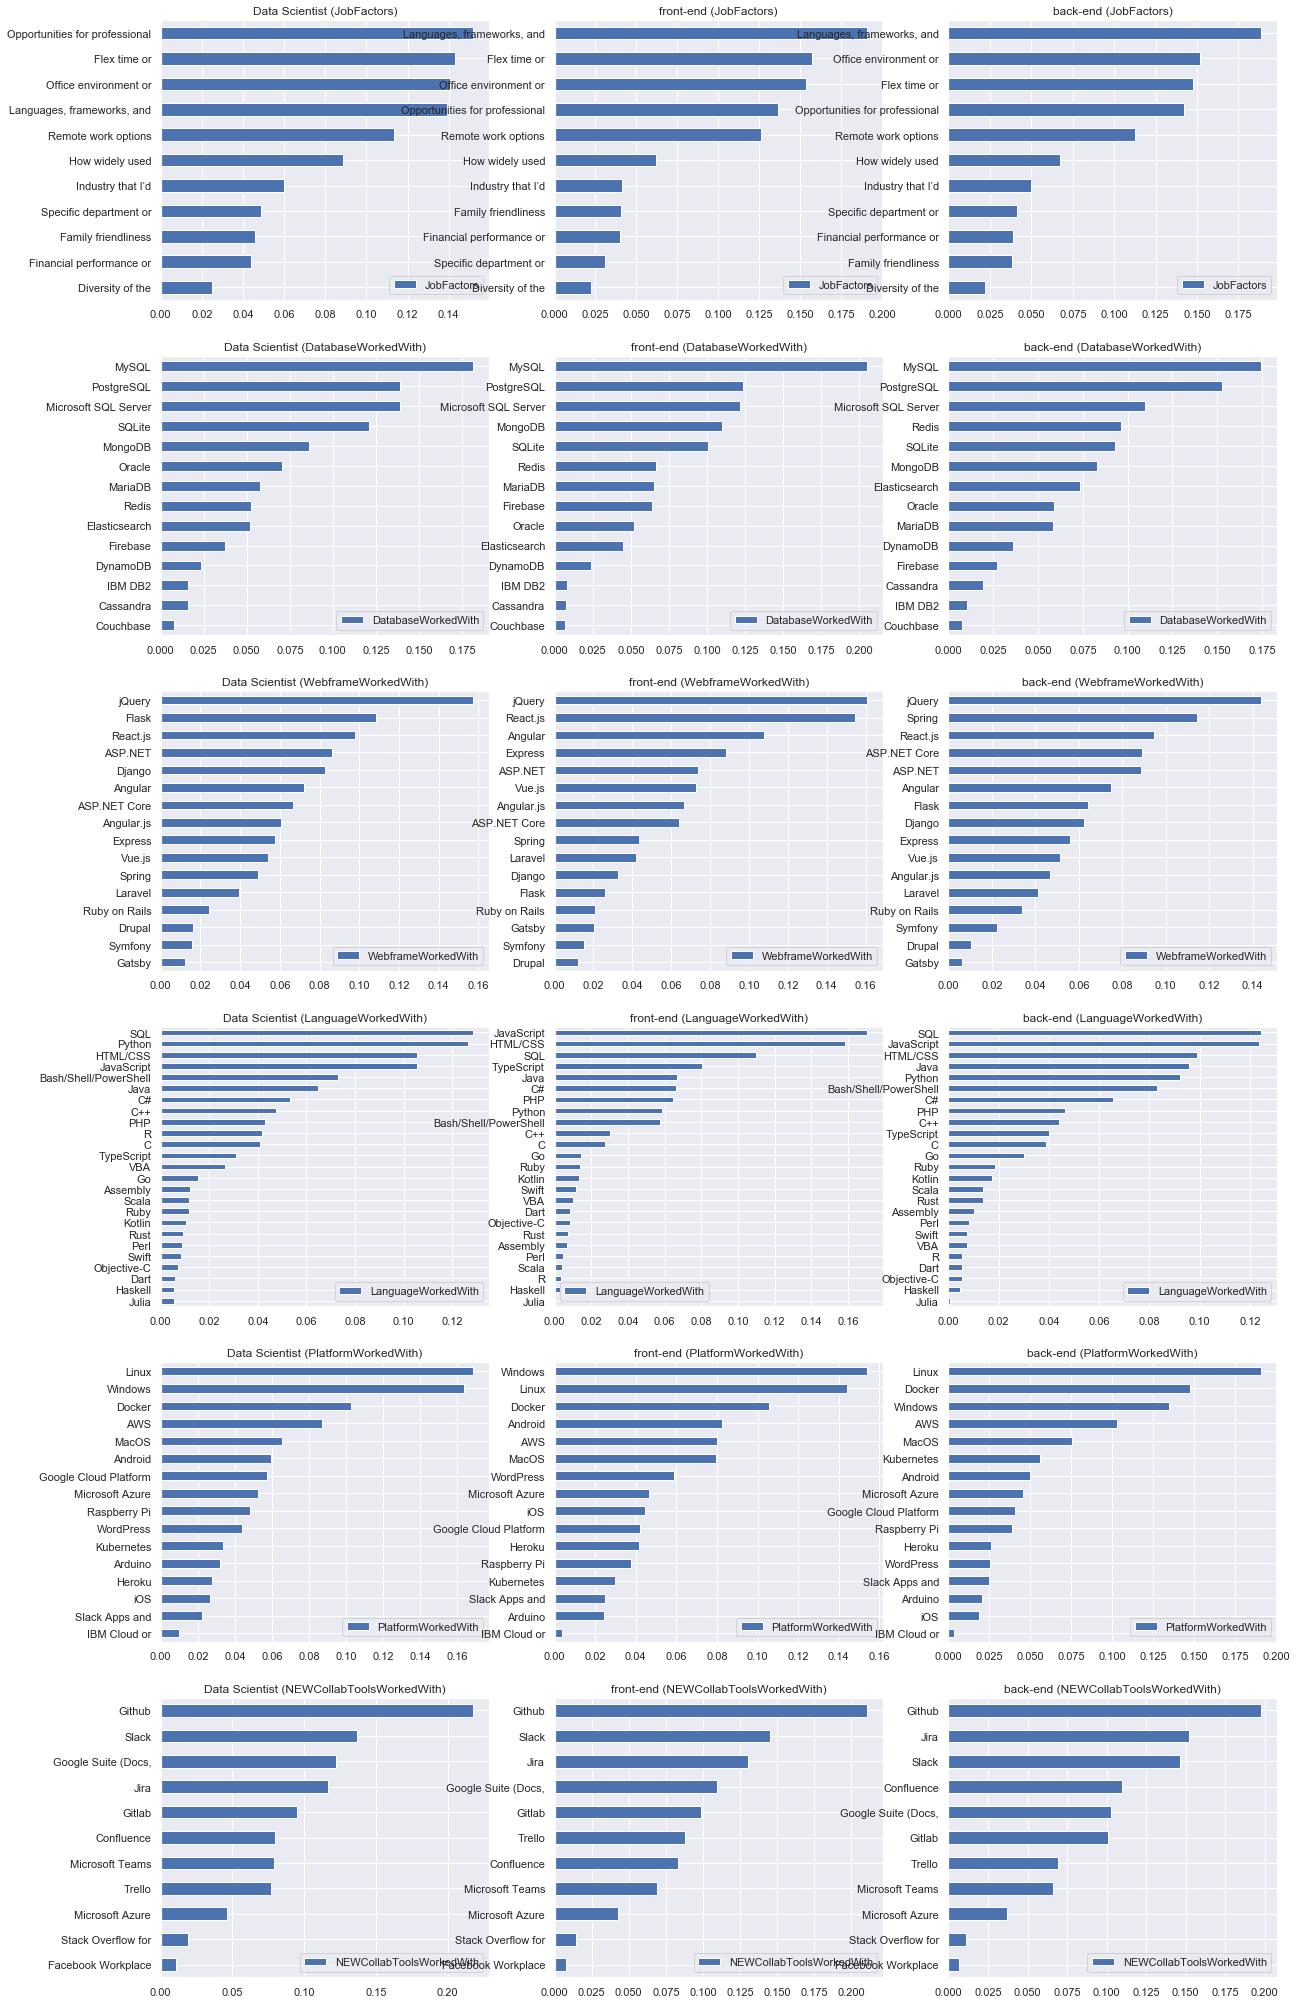

In [19]:
#basic setup
fig, axis = plt.subplots(len(multi_choice_columns),3,figsize=(20, 6*len(multi_choice_columns)))
row_index = 0 

for col in multi_choice_columns:
    col_index = 0
    for dev_type in dev_types_agg:
        
        #filter selected type of developers
        temp = df_interested[df_interested["DevType"]==dev_type].copy()
        temp = temp[~temp[col].isnull()]
        
        #split multi-choice values into a string and count their occurences
        temp[col] = temp[col].apply(lambda x: x.split(';') if isinstance(x,str) else np.nan)
        count_result = dict(Counter(temp[col].sum()))
        
        #prepare dataframe for plotting
        pd_count = pd.DataFrame.from_dict(count_result, orient='index',columns=[col]).sort_values(by=col)
        
        #select top 3 words for representing the value
        pd_count = pd_count.rename(index= lambda x: ' '.join(x.split(" ")[0:3]))
        pd_count = pd_count/pd_count[col].sum()

        #plot data
        axis[row_index, col_index].set_title(dev_type+" ("+ col+")")
        pd_count.plot(kind='barh', ax=axis[row_index,col_index])
        col_index = col_index + 1
    row_index = row_index + 1

### **Note:** We will <font color=red> ignore the null data </font>, since we are simply counting the occurance of each choice, so we don't need to handle missing values. We just simply assume that there is no suitable choice for those users (so that they select no option).

###### Findings at a glimps:
* Jobfactor: we can see that front-end & back-end developers cares about language & framework but data scientist care more about professional opportunities
* WebWorkedWith: we find Flask is quite popular between data scientist
* LanguageWorkedWith: its not surprised that python & SQL is the most popular language among data scientists

# 3. Data Preparation & Data Modeling

For our 4th question:
* What are important predictors for data scientists' who has higher converted compensation?

I think the quickest & easiest technique to answer this question is to use **Decision Tree Classifier** — which provides good explainability that allowed us to understand which feature sets may impact on our depend variable (“ConvertedComp”).<br>

Also, I decide to split user into 2 groups — “higher compensation group” versus “lower compensation group”, which i defined by their converted compensation larger or smaller than $100,000.

### **Note:** We will <font color=red> impute the null data </font> with "mean" strategy. Since we have remove extreme numeric values in previous section, so imputing mean would be a simple and intuitive way to impute numeric data.

In [21]:
from sklearn.impute import SimpleImputer
#we will focus on data scientist, and remove rows with null ConvertedComp
df_data_scientist = df_interested[(df_interested.DevType=="Data Scientist") & (~df_interested.ConvertedComp.isnull())]

#to simplify the modeling task, we only chose numeric_columns
modeling_df = df_data_scientist.copy()
modeling_df = modeling_df[numeric_columns]

#impute null numeric data with "mean". We have remove extreme value in previous section, so it won't affect our mean.
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
modeling_df = imp.fit_transform(modeling_df)
modeling_df = pd.DataFrame(data=modeling_df,columns=numeric_columns)

#we split user group by their ConvertedComp into 2 group - higher than 100,000 and lower than 100,000
modeling_df["ConvertedComp"] = modeling_df["ConvertedComp"]>=100000

In [22]:
modeling_df.head(3)

Age  Age1stCode  ConvertedComp  WorkWeekHrs  YearsCode  YearsCodePro
0  33.281347        14.0          False         37.0        4.0           2.0
1  34.000000        30.0          False         40.0        4.0           3.0
2  32.000000        21.0          False         45.0       10.0           6.0

In [23]:
#build & fit our decision tree model
from sklearn import tree
y = modeling_df["ConvertedComp"]
X = modeling_df.drop("ConvertedComp",axis=1)
clf = tree.DecisionTreeClassifier(random_state=3,max_depth=3)
clf = clf.fit(X, y)

# 4. Evaluate the Results

Decision tree model provides good explainability that allowed us to understand which feature sets may impact on our depend variable ("ConvertedComp"). They are also easy to visualize and convey the meanings, so i think its a powerful to understand our data & model works.

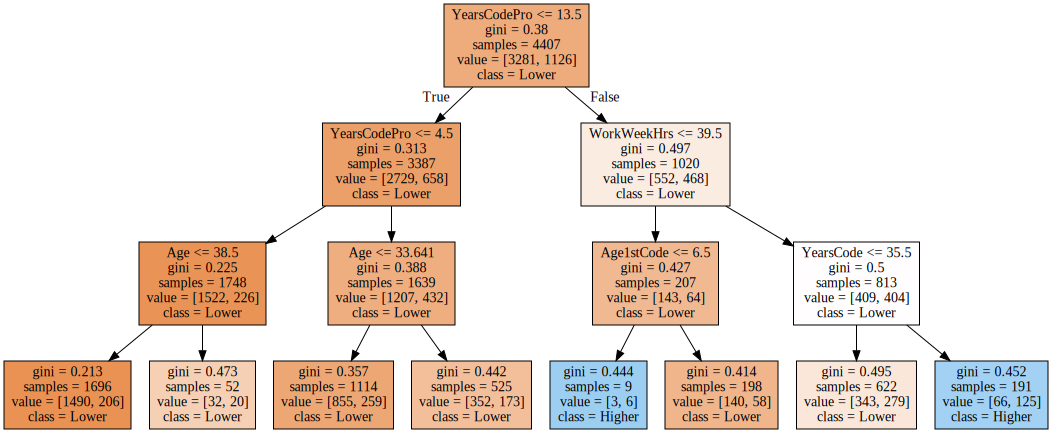

In [24]:
#graph our tree by graphviz
import graphviz
dot_data = tree.export_graphviz(clf, out_file=None, max_depth=3, 
                   feature_names = list(modeling_df.drop("ConvertedComp",axis=1).columns),
                   class_names=["Lower","Higher"],filled=True)

# Draw graph
graph = graphviz.Source(dot_data, format="png") 
graph

###### Findings at a glimps:
* the rightest group has the highest percentage of higher compensenation data scientists
* the rightest group - YearsCodePro > 13.5, WorkWeekHrs > 39.5, YearsCode > 35.5
* the leftest group has the lowest percentage of higher compensenation data scientists
* the leftest group - YearsCodePro <= 13.5, YearsCodePro <= 4.5, Age <= 38.5

The result quite make sense to me — if you coding for longer years, and working longer every week, you are more likely to have more than $100,000 converted compensation.